# Q1
先用51的包，确认这些SA的函数定义没问题

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def parse_tsp(file_name):
    with open(file_name, 'r') as file:
        lines = file.readlines()
        cities = []
        for line in lines:
            parts = line.split()
            if len(parts) == 3 and parts[0].isdigit():
                cities.append([float(parts[1]), float(parts[2])])
        return np.array(cities)  # 使用NumPy数组

# 创建距离矩阵
def create_distance_matrix(cities):
    num_cities = len(cities)
    distance_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        distance_matrix[i] = np.sqrt(np.sum((cities - cities[i])**2, axis=1))
    return distance_matrix

# 使用距离矩阵计算路径长度
def path_length(distance_matrix, tour):
    return np.sum(distance_matrix[tour, np.roll(tour, -1)])

# 解析 .opt.tour 文件，以获取最优路径
def parse_opt_tour(file_name):
    with open(file_name, 'r') as file:
        lines = file.readlines()
        opt_tour = []
        for line in lines:
            parts = line.split()
            if parts[0].isdigit():
                opt_tour.append(int(parts[0]) - 1)
        return np.array(opt_tour)  # 使用NumPy数组

# 2-opt 算法的交换部分也可以使用NumPy进行优化，但这需要对算法的具体实现进行更深入的修改。


In [5]:
# 解析 eli51.tsp 和 eli51.opt.tour 文件
cities = parse_tsp('eil51.tsp.txt')
distance_matrix = create_distance_matrix(cities)
opt_tour = parse_opt_tour('eil51.opt.tour.txt')
opt_length = path_length(distance_matrix, opt_tour)


In [6]:
# 2-opt 算法
def two_opt_swap(tour, i, j):
    new_tour = list(tour[:i])
    new_tour.extend(reversed(tour[i:j + 1]))
    new_tour.extend(tour[j + 1:])
    return np.array(new_tour)

# 移动单个城市的算法
def move_city(tour, city_index, new_position):
    city = tour[city_index]
    new_tour = np.delete(tour, city_index)  # 删除原位置的城市
    new_tour = np.insert(new_tour, new_position, city)  # 在新位置插入城市
    return new_tour

In [7]:
# 不同的冷却计划
def linear_cooling(current_temp, alpha, iteration):
    return current_temp - alpha

def exponential_cooling(current_temp, alpha, iteration):
    return current_temp * alpha

def logarithmic_cooling(current_temp, alpha, iteration):
    return current_temp / (1 + alpha * np.log(1 + iteration))

In [17]:
# 2-opt策略的模拟退火算法
def simulated_annealing_2_opt(distance_matrix, initial_temp, final_temp, alpha, cooling_schedule):
    current_temp = initial_temp
    current_tour = np.random.permutation(len(distance_matrix))
    current_length = path_length(distance_matrix, current_tour)
    lengths_over_iterations = [current_length]
    iteration = 1
    
    while current_temp > final_temp:
        for _ in range(len(distance_matrix)):
            i, j = np.sort(np.random.choice(len(distance_matrix), 2, replace=False))
            new_tour = two_opt_swap(current_tour, i, j)
            new_length = path_length(distance_matrix, new_tour)
            
            if new_length < current_length or np.random.rand() < np.exp((current_length - new_length) / current_temp):
                current_tour = new_tour
                current_length = new_length
         
        lengths_over_iterations.append(current_length)       
        current_temp = cooling_schedule(current_temp, alpha, iteration)
        iteration += 1
        # current_temp *= alpha #默认使用exponential
    
    return current_tour, current_length, lengths_over_iterations

# 移动城市策略的模拟退火算法
def simulated_annealing_move_city(distance_matrix, initial_temp, final_temp, alpha, cooling_schedule):
    current_temp = initial_temp
    current_tour = np.random.permutation(len(distance_matrix))
    current_length = path_length(distance_matrix, current_tour)
    lengths_over_iterations = [current_length]
    iteration = 1
    
    while current_temp > final_temp:
        for _ in range(len(cities)):
            city_index = np.random.randint(len(distance_matrix))
            new_position = np.random.randint(len(distance_matrix))
            new_tour = move_city(current_tour, city_index, new_position)
            new_length = path_length(distance_matrix, new_tour)
            
            if new_length < current_length or np.random.rand() < np.exp((current_length - new_length) / current_temp):
                current_tour = new_tour
                current_length = new_length
        
        lengths_over_iterations.append(current_length)    
        current_temp = cooling_schedule(current_temp, alpha, iteration)
        iteration += 1
        # current_temp *= alpha #默认使用exponential

    return current_tour, current_length, lengths_over_iterations

In [18]:
def multiple_runs_simulated_annealing(distance_matrix, runs, initial_temp, final_temp, alpha, method, cooling_schedule):
    best_tour = None
    best_length = float('inf')
    best_lengths_over_iterations = []

    for _ in range(runs):
        if method == '2-opt':
            tour, length, lengths = simulated_annealing_2_opt(distance_matrix, initial_temp, final_temp, alpha, cooling_schedule)
        elif method == 'move_city':
            tour, length, lengths = simulated_annealing_move_city(distance_matrix, initial_temp, final_temp, alpha, cooling_schedule)
        else:
            raise ValueError("Unknown method")

        if length < best_length:
            best_tour = tour
            best_length = length
            best_lengths_over_iterations = lengths

    return best_tour, best_length, best_lengths_over_iterations


In [ ]:
# 设置参数
runs = 1  # 运行次数
initial_temp = 10000  # 初始温度
final_temp = 0.01    # 最终温度
alpha = 0.999         # 冷却率

# 运行模拟退火算法多次，使用2-opt
best_tour_2opt, best_length_2opt = multiple_runs_simulated_annealing(distance_matrix, runs, initial_temp, final_temp, alpha, '2-opt', exponential_cooling)
# 运行模拟退火算法多次，使用移动城市策略
best_tour_move_city, best_length_move_city = multiple_runs_simulated_annealing(distance_matrix, runs, initial_temp, final_temp, alpha, 'move_city', exponential_cooling)

print("使用2-opt找到的最佳路径长度:", best_length_2opt)
print("使用移动城市策略找到的最佳路径长度:", best_length_move_city)
print("最优路径长度:", opt_length)

# 跑一下280的包

In [ ]:
# 导入280数据
cities = parse_tsp('a280.tsp.txt')
distance_matrix = create_distance_matrix(cities)
opt_tour = parse_opt_tour('a280.opt.tour.txt')
opt_length280 = path_length(distance_matrix, opt_tour)


# 设置参数
runs = 1  # 运行次数
initial_temp = 10000  # 初始温度
final_temp = 1    # 最终温度
alpha = 0.997         # 冷却率

# 运行模拟退火算法多次，使用2-opt
best_tour_2opt_280, best_length_2opt_280 = multiple_runs_simulated_annealing(distance_matrix, runs, initial_temp, final_temp, alpha, '2-opt', exponential_cooling)

# 运行模拟退火算法多次，使用移动城市策略
best_tour_move_city_280, best_length_move_city_280 = multiple_runs_simulated_annealing(distance_matrix, runs, initial_temp, final_temp, alpha, 'move_city', exponential_cooling)

print("使用2-opt找到的最佳路径长度:", best_length_2opt_280)
print("使用移动城市策略找到的最佳路径长度:", best_length_move_city_280)
print("最优路径长度:", opt_length280)

# Q2

针对280文件包进行，接下来的分析都围绕这个包展开

In [13]:
# 导入280数据
cities = parse_tsp('a280.tsp.txt')
distance_matrix = create_distance_matrix(cities)
opt_tour = parse_opt_tour('a280.opt.tour.txt')
opt_length280 = path_length(distance_matrix, opt_tour)


### 比较cooling

In [14]:
# 设置参数
runs = 1  # 每种策略和冷却计划的运行次数
initial_temp = 10000  # 初始温度
final_temp = 1        # 最终温度
alpha = 0.995          # 冷却率

# 这里假设您已经有了其他函数的定义，如 simulated_annealing_2_opt 和 simulated_annealing_move_city

# def multiple_runs_simulated_annealing(distance_matrix, runs, initial_temp, final_temp, alpha, method, cooling_schedule):
#     best_tour = None
#     best_length = float('inf')

#     for _ in range(runs):
#         if method == '2-opt':
#             tour, length = simulated_annealing_2_opt(distance_matrix, initial_temp, final_temp, alpha, cooling_schedule)
#         elif method == 'move_city':
#             tour, length = simulated_annealing_move_city(distance_matrix, initial_temp, final_temp, alpha, cooling_schedule)
#         else:
#             raise ValueError("Unknown method")

#         if length < best_length:
#             best_tour = tour
#             best_length = length

#     return best_tour, best_length

# 使用不同的冷却计划运行模拟退火算法
for cooling_schedule in [linear_cooling, exponential_cooling, logarithmic_cooling]:
    best_tour_2opt, best_length_2opt = multiple_runs_simulated_annealing(distance_matrix, runs, initial_temp, final_temp, alpha, '2-opt', cooling_schedule)
    best_tour_move_city, best_length_move_city = multiple_runs_simulated_annealing(distance_matrix, runs, initial_temp, final_temp, alpha, 'move_city', cooling_schedule)
    
    print(f"Cooling Schedule: {cooling_schedule.__name__}")
    print(f"  Best Length with 2-opt: {best_length_2opt}")
    print(f"  Best Length with Move City: {best_length_move_city}\n")

Cooling Schedule: linear_cooling
  Best Length with 2-opt: 7833.412300296899
  Best Length with Move City: 9669.505052015878

Cooling Schedule: exponential_cooling
  Best Length with 2-opt: 3065.417076419654
  Best Length with Move City: 3944.1358554676417

Cooling Schedule: logarithmic_cooling
  Best Length with 2-opt: 17263.49709782513
  Best Length with Move City: 18388.006696103002



### Plot

首先不同冷却策略的收敛图

In [20]:
# 设置参数
runs = 5  # 运行次数
initial_temp = 10000  # 初始温度
final_temp = 1    # 最终温度
alpha = 0.997         # 冷却率

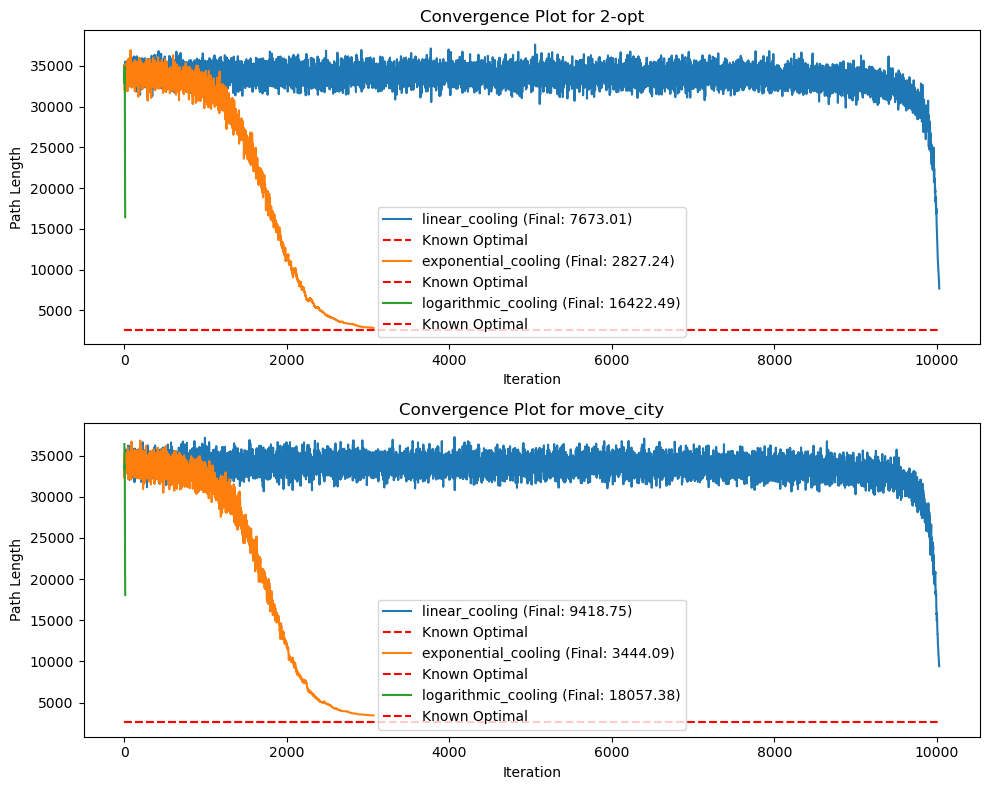

In [21]:
import matplotlib.pyplot as plt

# 收集不同冷却策略和优化方法的数据
data = {}
for cooling_schedule in [linear_cooling, exponential_cooling, logarithmic_cooling]:
    for method in ['2-opt', 'move_city']:
        _, best_length, lengths = multiple_runs_simulated_annealing(distance_matrix, runs, initial_temp, final_temp, alpha, method, cooling_schedule)
        data[(cooling_schedule.__name__, method)] = lengths
        
# 已知的最优路径长度
known_optimal_length = 2586.77 # 这里放入已知的最优路径长度

# 绘制收敛图并在图表上显示结果
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
for i, method in enumerate(['2-opt', 'move_city']):
    for cooling_schedule_name in ['linear_cooling', 'exponential_cooling', 'logarithmic_cooling']:
        lengths = data[(cooling_schedule_name, method)]
        axs[i].plot(lengths, label=f"{cooling_schedule_name} (Final: {lengths[-1]:.2f})")
        axs[i].hlines(known_optimal_length, 0, len(lengths)-1, colors='r', linestyles='dashed', label='Known Optimal')

    axs[i].set_title(f'Convergence Plot for {method}')
    axs[i].set_xlabel('Iteration')
    axs[i].set_ylabel('Path Length')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np


# 之前的函数定义（parse_tsp, distance, path_length, two_opt_swap, parse_opt_tour, calculate_opt_length）

def two_opt_swap(tour, i, j):
    new_tour = np.concatenate([tour[:i], tour[i:j + 1][::-1], tour[j + 1:]])
    return new_tour

def simulated_annealing(cities, initial_temp, final_temp, alpha, cooling_schedule):
    current_temp = initial_temp
    best_tour = np.random.permutation(len(cities))
    best_length = path_length(cities, best_tour)
    iteration = 1
    lengths = []  # 用于记录每次迭代的最佳路径长度

    while current_temp > final_temp:
        for _ in range(len(cities)):
            i, j = np.sort(np.random.choice(len(cities), 2, replace=False))
            new_tour = two_opt_swap(best_tour, i, j)
            new_length = path_length(cities, new_tour)

            if new_length < best_length or np.random.rand() < np.exp((best_length - new_length) / current_temp):
                best_tour = new_tour
                best_length = new_length

        lengths.append(best_length)  # 记录当前最佳长度
        current_temp = cooling_schedule(current_temp, alpha, iteration)
        iteration += 1

    return best_length, lengths

# 不同的冷却计划定义（linear_cooling, exponential_cooling, logarithmic_cooling）

def multiple_runs_simulated_annealing(cities, runs, initial_temp, final_temp, alpha, cooling_schedule):
    best_lengths = []
    
    for _ in range(runs):
        _, lengths = simulated_annealing(cities, initial_temp, final_temp, alpha, cooling_schedule)
        best_lengths.append(lengths)
    
    return best_lengths



# 设置参数
runs = 5  # 运行次数减少以减少计算时间
initial_temp = 10000
final_temp = 0.01
alpha = 0.997

# 绘制收敛速度图
plt.figure(figsize=(15, 5))
for name, strategy in cooling_strategies.items():
    lengths = multiple_runs_simulated_annealing(cities, runs, initial_temp, final_temp, alpha, strategy)
    avg_lengths = np.mean(lengths, axis=0)
    plt.plot(avg_lengths, label=name)

plt.axhline(y=opt_length, color='r', linestyle='--', label='Optimal Length')
plt.xlabel('Iteration')
plt.ylabel('Path Length')
plt.title('Convergence Speed of Different Cooling Schedules')
plt.legend()
plt.show()

# t test

In [ ]:
import numpy as np
from scipy import stats

def collect_data(runs, distance_matrix, initial_temp, final_temp, alpha):
    results_2opt = []
    results_move_city = []

    for _ in range(runs):
        _, length_2opt = simulated_annealing_2_opt(distance_matrix, initial_temp, final_temp, alpha, exponential_cooling)
        _, length_move_city = simulated_annealing_move_city(distance_matrix, initial_temp, final_temp, alpha, exponential_cooling)
        
        results_2opt.append(length_2opt)
        results_move_city.append(length_move_city)

    return results_2opt, results_move_city

# Collect data
runs = 100  # Increase the number of runs for better statistical significance
results_2opt, results_move_city = collect_data(runs, distance_matrix, initial_temp, final_temp, alpha)

# Perform t-test
t_stat, p_value = stats.ttest_ind(results_2opt, results_move_city, nan_policy='omit')

# Output
print("2-opt mean path length:", np.mean(results_2opt))
print("Move-city mean path length:", np.mean(results_move_city))
print("t-statistic:", t_stat)
print("p-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("There is a significant difference between the two strategies")
else:
    print("There is no significant difference between the two strategies")

# Q3


In [ ]:
def exponential_cooling(current_temp, alpha, iteration):
    return current_temp * alpha

def simulated_annealing(cities, initial_temp, final_temp, alpha, cooling_schedule, markov_chain_length):
    current_temp = initial_temp
    best_tour = np.random.permutation(len(cities))
    best_length = path_length(cities, best_tour)
    iteration = 1  # 初始化迭代变量
    lengths = [best_length]

    while current_temp > final_temp:
        for _ in range(markov_chain_length):
            i, j = np.sort(np.random.choice(len(cities), 2, replace=False))
            new_tour = two_opt_swap(best_tour, i, j)
            new_length = path_length(cities, new_tour)

            if new_length < best_length or np.random.rand() < np.exp((best_length - new_length) / current_temp):
                best_tour = new_tour
                best_length = new_length
        
        lengths.append(best_length)  # 在每次温度变化后记录路径长度
        current_temp = cooling_schedule(current_temp, alpha, iteration)  # 使用当前迭代次数更新温度
        iteration += 1  # 增加迭代次数

    return best_length, lengths


markov_lengths = [1, 10, 50, 100, 200]  # 可根据需要调整这些值
results = {}

for length in markov_lengths:
    _, lengths = simulated_annealing(cities, initial_temp, final_temp, alpha, exponential_cooling, length)
    results[length] = lengths
    
# 修改绘图代码部分
plt.figure(figsize=(15, 5))
for length in markov_lengths:
    _, lengths = simulated_annealing(cities, initial_temp, final_temp, alpha, exponential_cooling, length)
    plt.plot(range(len(lengths)), lengths, label=f'Markov Chain Length {length}')  # 使用正确的迭代次数范围

plt.axhline(y=opt_length, color='r', linestyle='--', label='Optimal Length')
plt.xlabel('Iteration')
plt.ylabel('Path Length')
plt.title('Effects of Markov Chain Length on Convergence')
plt.legend()
plt.show()